# CAB420, Week 4 Practical, Question 1 Solution
## Kuzushiji-MNIST and Kuzushiji-MNIST-49

The Kuzushiji-MNIST database is a MNIST like database based on Japanese Kuzushiji characters. Following the pattern of MNIST, it contains gresyscale images of size 28x28 pixels for 10 Kuzushiji characters. A second expanded dataset, Kuzushiji-MNIST-49, has the same format but 49 different characters. The dataset is also imbalanced, in that not every class has the same number of instances and some classes are rarer than others. Using these two datasets:
* Create and train a network to classify the Kuzushiji-MNIST database into it's 10 classes. Evaluate the network on the test set.
* Extend the network to classify the Kuzushiji-MNIST-49 dataset into it's 49 classes. Evaluate the network on the test set, and consider the frequency with which each class occurs when analysing results.

Note that you do not need to try to make your networks overly complex, or train them for more than a few minutes. Smaller networks and training times of 5-10 epochs will be sufficient for this tutorial. However you are encouraged to experiment with different architectures and explore how they impact performance.

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import scipy.io
import numpy

## Part 1: K-MNIST
Data loading. Using scipy to load the data

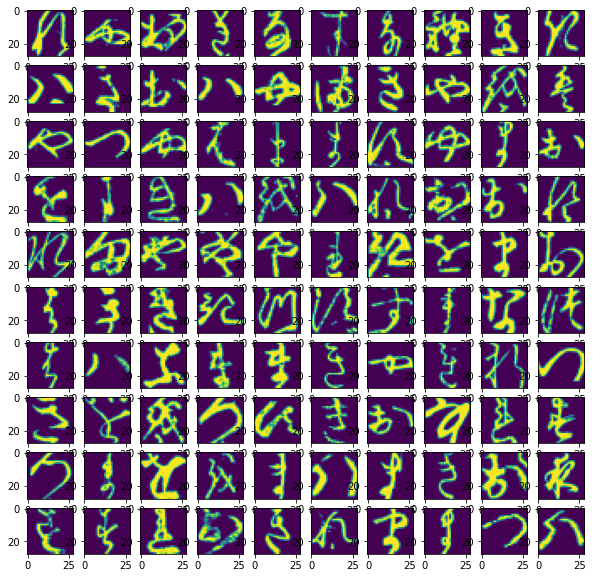

In [2]:
kmnist_train = scipy.io.loadmat('../../data/kmnist/kmnist_train.mat')
kmnist_test = scipy.io.loadmat('../../data/kmnist/kmnist_test.mat')

fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(kmnist_train['imgs'][:,:,i])

Have a quick look at the data. It's always good to make sure we have what we expect.

In [3]:
print(numpy.shape(kmnist_train['imgs']))
print(kmnist_train['imgs'][:,:,1])
print(numpy.shape(kmnist_train['labels']))

(28, 28, 50000)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0

We need to reshape our data so such that the first index is the sample index, and convert it into a 4D structure

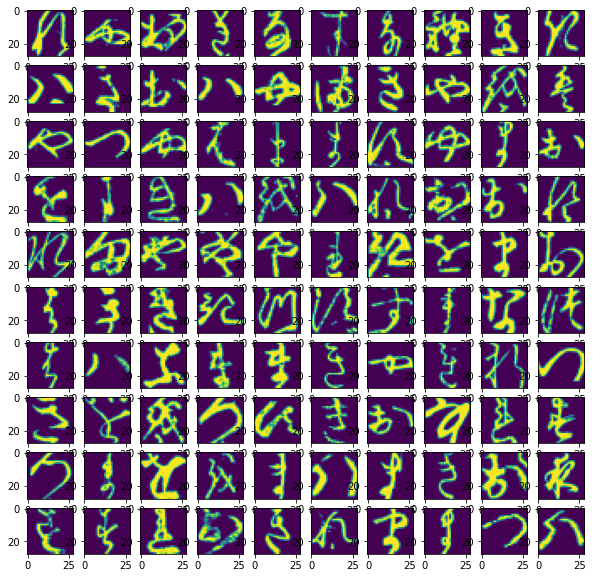

In [4]:
train = numpy.transpose(kmnist_train['imgs'], (2, 0, 1)).reshape(-1, 28, 28, 1)
train_y = kmnist_train['labels']
test = numpy.transpose(kmnist_test['imgs'], (2, 0, 1)).reshape(-1, 28, 28, 1)
test_y = kmnist_test['labels']

fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(train[i,:,:,0])

### The Network

This is taken from the first week 4 lecture example.

I've defined the number of training epochs here as (essentially) a global constant. Note that I've run this on my GPU desktop. You may want to scale this back for your laptop, and in particular for the network at the very bottom of this if you plan to re-run it.

In [5]:
num_epochs = 25

# function to build a model, takes the number of classes. Can optionally change the output activation. 
# See the discussion at bottom of this script for more details about that.
def build_model(num_classes, output_activation=None):
    # our model, input in an image shape
    inputs = keras.Input(shape=(28, 28, 1, ), name='img')
    # run pairs of conv layers, all 3s3 kernels
    x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation=None)(x)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
    # than dropping out 20% of the invidual pixels
    x = layers.SpatialDropout2D(0.2)(x)
    # max pooling, 2x2, which will downsample the image
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    # rinse and repeat with 2D convs, batch norm, dropout and max pool
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    # final conv2d, batch norm and spatial dropout
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)

    # flatten layer
    x = layers.Flatten()(x)
    # we'll use a couple of dense layers here, mainly so that we can show what another dropout layer looks like 
    # in the middle
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    # the output
    outputs = layers.Dense(num_classes, activation=output_activation)(x)

    # build the model, and print a summary
    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='kmnist_cnn_model')
    
    return model_cnn

model_cnn = build_model(10)
model_cnn.summary()

Model: "kmnist_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 8)         0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)    

### Train the model

We're only going to train for 10 epochs. This could easily run longer, but for the sake of speed we'll keep it short.

In [6]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(train, train_y,
                        batch_size=128,
                        epochs=num_epochs,
                        validation_data=(test, test_y))

Epoch 1/25
391/391 [==============================] - 4s 7ms/step - loss: 1.1147 - accuracy: 0.6327 - val_loss: 0.5756 - val_accuracy: 0.8130
Epoch 2/25
391/391 [==============================] - 2s 6ms/step - loss: 0.3379 - accuracy: 0.8977 - val_loss: 0.3934 - val_accuracy: 0.8823
Epoch 3/25
391/391 [==============================] - 3s 7ms/step - loss: 0.2360 - accuracy: 0.9297 - val_loss: 0.3119 - val_accuracy: 0.9127
Epoch 4/25
391/391 [==============================] - 3s 8ms/step - loss: 0.1837 - accuracy: 0.9442 - val_loss: 0.2734 - val_accuracy: 0.9229
Epoch 5/25
391/391 [==============================] - 3s 7ms/step - loss: 0.1529 - accuracy: 0.9554 - val_loss: 0.2526 - val_accuracy: 0.9281
Epoch 6/25
391/391 [==============================] - 2s 6ms/step - loss: 0.1354 - accuracy: 0.9583 - val_loss: 0.2128 - val_accuracy: 0.9409
Epoch 7/25
391/391 [==============================] - 2s 6ms/step - loss: 0.1152 - accuracy: 0.9660 - val_loss: 0.2254 - val_accuracy: 0.9402
Epoch 

### Evaluate the Results

Borrowing again from the week 4 lecture example, and my eval model function.

313/313 - 0s - loss: 0.1721 - accuracy: 0.9612
Test loss: 0.17209480702877045
Test accuracy: 0.9611999988555908


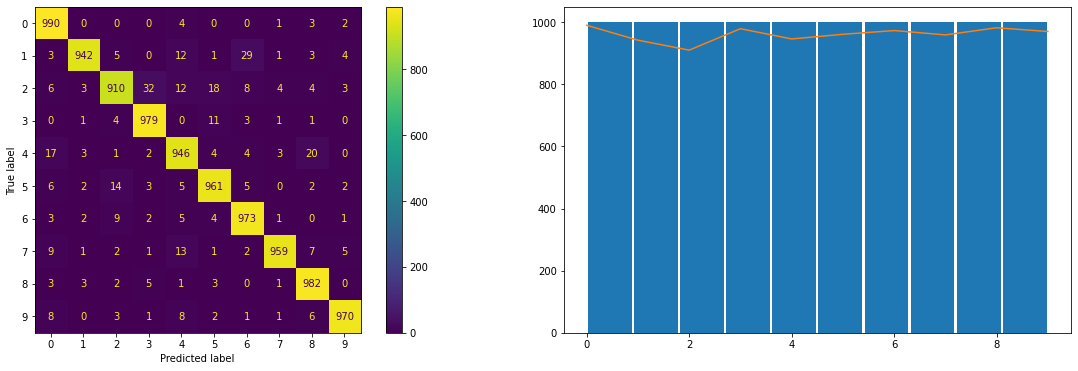

In [7]:
def eval_model(model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)

    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 2, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(len(numpy.unique(y_test))))
    c.plot(ax = ax)

    ax = fig.add_subplot(1, 2, 2)
    ax.hist(y_test, bins=len(numpy.diagonal(cm)), rwidth=0.95)
    ax.plot(numpy.diagonal(cm))

eval_model(model_cnn, test, test_y)

We can see a few things from the above training and evaluation:
* The model probably hasn't converged fully
* Performance is fairly consistent across all classes and classes are evenly distributed

## Part 2: K-MNIST 49
We'll repeat now using the 49 class version of the data. This largely follows the above part 1.

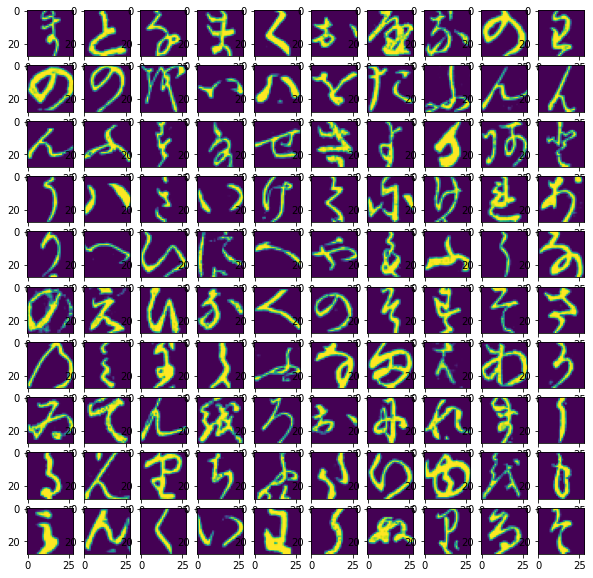

In [8]:
kmnist_train = scipy.io.loadmat('../../data/kmnist/kmnist49_train.mat')
kmnist_test = scipy.io.loadmat('../../data/kmnist/kmnist49_test.mat')
train = numpy.transpose(kmnist_train['imgs'], (2, 0, 1)).reshape(-1, 28, 28, 1)
train_y = kmnist_train['labels']
test = numpy.transpose(kmnist_test['imgs'], (2, 0, 1)).reshape(-1, 28, 28, 1)
test_y = kmnist_test['labels']

fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(train[i,:,:,0])

### The Model
Exactly the same as last time - that's why I created a function for it. We're just going to increase the number of classes to 49 to match the different dataset.

In [9]:
model_cnn = build_model(49)
model_cnn.summary()

Model: "kmnist_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 8)         32        
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 8)         0         
_________________________________________________________________
spatial_dropout2d_3 (Spatial (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 8)    

In [10]:

model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(train, train_y,
                        batch_size=128,
                        epochs=num_epochs,
                        validation_data=(test, test_y))

Epoch 1/25
1816/1816 [==============================] - 16s 9ms/step - loss: 1.8480 - accuracy: 0.5208 - val_loss: 0.7151 - val_accuracy: 0.8089
Epoch 2/25
1816/1816 [==============================] - 18s 10ms/step - loss: 0.6029 - accuracy: 0.8333 - val_loss: 0.5129 - val_accuracy: 0.8636
Epoch 3/25
1816/1816 [==============================] - 18s 10ms/step - loss: 0.4503 - accuracy: 0.8753 - val_loss: 0.4279 - val_accuracy: 0.8860
Epoch 4/25
1816/1816 [==============================] - 18s 10ms/step - loss: 0.3800 - accuracy: 0.8950 - val_loss: 0.3668 - val_accuracy: 0.9018
Epoch 5/25
1816/1816 [==============================] - 17s 10ms/step - loss: 0.3357 - accuracy: 0.9065 - val_loss: 0.3293 - val_accuracy: 0.9130
Epoch 6/25
1816/1816 [==============================] - 17s 9ms/step - loss: 0.3041 - accuracy: 0.9159 - val_loss: 0.3062 - val_accuracy: 0.9190
Epoch 7/25
1816/1816 [==============================] - 15s 8ms/step - loss: 0.2916 - accuracy: 0.9195 - val_loss: 0.2949 - va

1205/1205 - 3s - loss: 0.2198 - accuracy: 0.9453
Test loss: 0.21976375579833984
Test accuracy: 0.9453394412994385


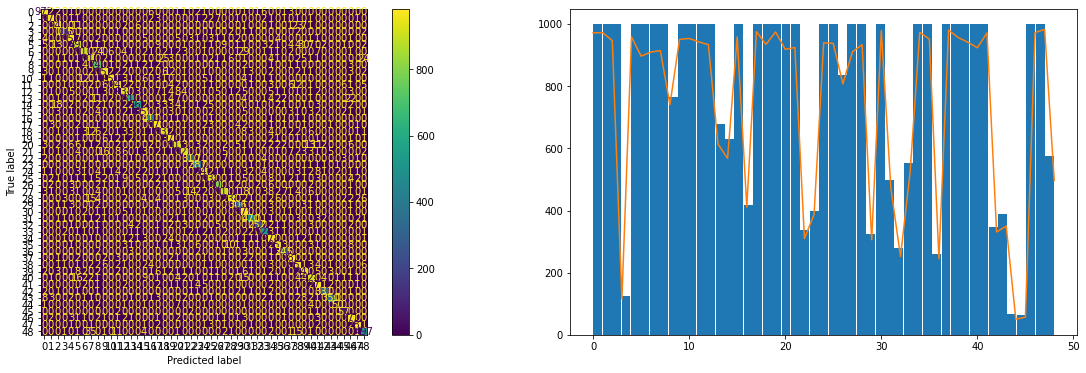

In [11]:
eval_model(model_cnn, test, test_y)

The model doesn't works ok, but we have massive class imbalance. Our network actually performs quite well in the presence of this, yet all the same let's add some class weights in and see what happens.

### Adjusting Class Weights

We can use sklean to get the class weight for us, though we need to convert them into a dictionary for keras.

In [12]:
import sklearn.utils
class_weights = sklearn.utils.compute_class_weight('balanced',
                                                 numpy.unique(train_y.flatten()),
                                                 train_y.flatten())
print(class_weights)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weights_dict)

[ 0.79035714  0.79035714  0.79035714  6.10314396  0.79035714  0.79035714
  0.79035714  0.79035714  1.00597006  0.79035714  0.79035714  0.79035714
  0.79035714  1.13856971  1.22631054  0.79035714  1.84878864  0.79035714
  0.79035714  0.79035714  0.79035714  0.79035714  2.29866353  1.93477881
  0.79035714  0.79035714  0.92403407  0.79035714  0.79035714  2.37939933
  0.79035714  1.54971989  2.76026942  1.39721357  0.79035714  0.79035714
  2.96754872  0.79035714  0.79035714  0.79035714  0.79035714  0.79035714
  2.21699058  1.97836581 11.37204522 12.09730321  0.79035714  0.79035714
  1.34605247]
{0: 0.7903571428571429, 1: 0.7903571428571429, 2: 0.7903571428571429, 3: 6.103143960286817, 4: 0.7903571428571429, 5: 0.7903571428571429, 6: 0.7903571428571429, 7: 0.7903571428571429, 8: 1.005970058791442, 9: 0.7903571428571429, 10: 0.7903571428571429, 11: 0.7903571428571429, 12: 0.7903571428571429, 13: 1.1385697135997257, 14: 1.2263105397317966, 15: 0.7903571428571429, 16: 1.8487886382623224, 17: 0

/home/denman/src/venvs/cab420/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48], y=[30 19 20 ... 10 39 30] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Comparing the class weights to the histogram above, we see that these make a lot of sense. Classes that were comparitively small have a high weight, those with lots of examples have a low weight.

We can pass that info directly to the model.fit call and use that to help train the model.

In [13]:
model_cnn = build_model(49)
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [14]:
history = model_cnn.fit(train, train_y,
                        batch_size=128,
                        epochs=num_epochs,
                        validation_data=(test, test_y), 
                        class_weight=class_weights_dict)

Epoch 1/25
1816/1816 [==============================] - 17s 9ms/step - loss: 2.0639 - accuracy: 0.4633 - val_loss: 0.8747 - val_accuracy: 0.7666
Epoch 2/25
1816/1816 [==============================] - 17s 9ms/step - loss: 0.7065 - accuracy: 0.8021 - val_loss: 0.6273 - val_accuracy: 0.8268
Epoch 3/25
1816/1816 [==============================] - 17s 10ms/step - loss: 0.5107 - accuracy: 0.8538 - val_loss: 0.4946 - val_accuracy: 0.8658
Epoch 4/25
1816/1816 [==============================] - 18s 10ms/step - loss: 0.4142 - accuracy: 0.8808 - val_loss: 0.4177 - val_accuracy: 0.8894
Epoch 5/25
1816/1816 [==============================] - 19s 11ms/step - loss: 0.3651 - accuracy: 0.8950 - val_loss: 0.4007 - val_accuracy: 0.8935
Epoch 6/25
1816/1816 [==============================] - 19s 10ms/step - loss: 0.3285 - accuracy: 0.9049 - val_loss: 0.3688 - val_accuracy: 0.9022
Epoch 7/25
1816/1816 [==============================] - 18s 10ms/step - loss: 0.3019 - accuracy: 0.9118 - val_loss: 0.3474 - v

1205/1205 - 4s - loss: 0.2463 - accuracy: 0.9377
Test loss: 0.246327206492424
Test accuracy: 0.9377124309539795


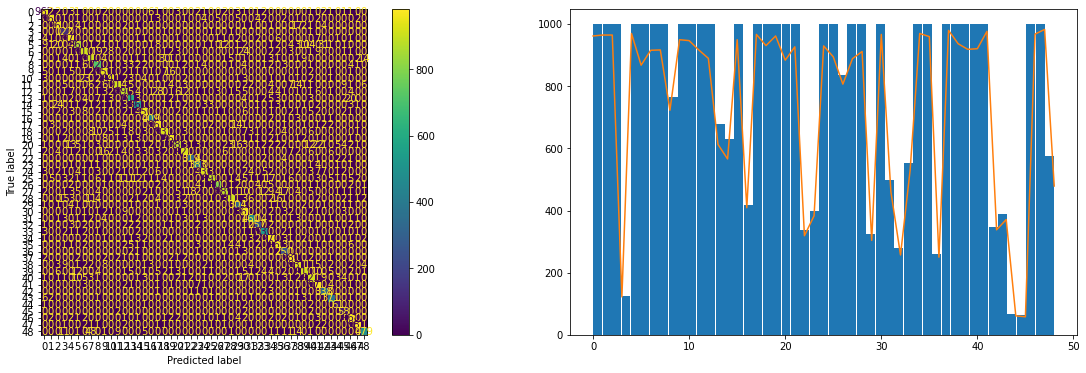

In [15]:
eval_model(model_cnn, test, test_y)

Training that network again, we see that our performance is similar to before, and has perhaps dropped a bit over what we had above. Remembering back to what we saw in week 3 with using class weights with SVMs, this is not surprising. By using the class weights we aim to improve performance for classes we have few instances of; at the possible cost of classes that we have lots of data of.

What this means is that we tend to make more errors on the really common classes, and because those classes are really common, we make more errors overall. Looking at our histogram, we see that for the really rare classes, we're still doing very badly. For the ones that we have a moderate amount of data for, we've typically improved a bit, and we've dropped a bit for some of the more common classes.

## A Note on SparseCategoricalCrossentropy

Above, we see that compared to MATLAB we take a shortcut - we just use our training labels as is and don't need to force them into a one-hot representation. 

MATLAB forces us to put data into a categorical data type, which gives us the one-hot vector format to match our output. Keras allows us to do this too, but also allows us to feed in the labels and use the loss function we've been using:
`keras.losses.SparseCategoricalCrossentropy(from_logits=True),`

This works fine, as long as you have an activation of `None` on your ouput layer. If you put a softmax on the output, you may see a performance drop, in particular for KMNIST-49 with the large number of classes and class imbalance.

If you want to convert data to a one-hot representation and work with that, we can do that as follows.

The first thing that we'll do is convert out labels, and helpfully there's a keras function for this.

In [16]:
from tensorflow.keras.utils import to_categorical

train_y = to_categorical(kmnist_train['labels'], 49)
test_y = to_categorical(kmnist_test['labels'], 49)

From this point we'll pretty much continue as per our last attempt, so we'll use class weights again.

We have two changes to make now:
* Our final layer (the output) needs to have a soft-max activation
* Our loss needs to change. We now have a genuine one-hot representation, so we can use the standard categorical_crossentropy.

In [17]:
model_cnn = build_model(49, 'softmax')
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(train, train_y,
                        batch_size=128,
                        epochs=num_epochs,
                        validation_data=(test, test_y), 
                        class_weight=class_weights_dict)

Epoch 1/25
1816/1816 [==============================] - 16s 9ms/step - loss: 2.0644 - accuracy: 0.4627 - val_loss: 0.9042 - val_accuracy: 0.7561
Epoch 2/25
1816/1816 [==============================] - 17s 9ms/step - loss: 0.6915 - accuracy: 0.8044 - val_loss: 0.6000 - val_accuracy: 0.8346
Epoch 3/25
1816/1816 [==============================] - 16s 9ms/step - loss: 0.5040 - accuracy: 0.8565 - val_loss: 0.4942 - val_accuracy: 0.8668
Epoch 4/25
1816/1816 [==============================] - 17s 9ms/step - loss: 0.4254 - accuracy: 0.8777 - val_loss: 0.4283 - val_accuracy: 0.8826
Epoch 5/25
1816/1816 [==============================] - 15s 8ms/step - loss: 0.3718 - accuracy: 0.8913 - val_loss: 0.4008 - val_accuracy: 0.8913
Epoch 6/25
1816/1816 [==============================] - 15s 8ms/step - loss: 0.3366 - accuracy: 0.9015 - val_loss: 0.3624 - val_accuracy: 0.9028
Epoch 7/25
1816/1816 [==============================] - 16s 9ms/step - loss: 0.3094 - accuracy: 0.9086 - val_loss: 0.3767 - val_ac

We need to modify our eval_model function slightly to deal with the different data type for our test labels.

In [ ]:
def eval_model(model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(y_test, axis=1)

    cm = confusion_matrix(gt_idx, indexes)
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 2, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(49))
    c.plot(ax = ax)

    ax = fig.add_subplot(1, 2, 2)
    ax.hist(gt_idx, bins=len(numpy.diagonal(cm)), rwidth=0.95)
    ax.plot(numpy.diagonal(cm))

eval_model(model_cnn, test, test_y)

1205/1205 - 2s - loss: 0.2467 - accuracy: 0.9378
Test loss: 0.24667608737945557
Test accuracy: 0.9378421306610107


Overall results don't really vary from what we had - but this is (perhaps) a little clearer as to what is happening in the loss function